# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

**Important: Restart the Kernel at this moment**

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create training set and define training dataloader
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I chose to convert the images to tensors and normalize them to have a mean of 0.5 and a standard deviation of 0.5 for each channel. This normalization helps to center the data around zero, which can improve the convergence of the neural network during training. Additionally, normalizing the images can help to reduce the impact of varying lighting conditions and contrast in the handwritten digits, making it easier for the model to learn relevant features.

About the preprocessing steps, I did not include any data augmentation techniques such as random rotations or flips because the MNIST dataset consists of grayscale images of handwritten digits, which are relatively uniform in terms of orientation and scale. Therefore, I focused on basic normalization to ensure that the pixel values are in a suitable range for training the neural network.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

7


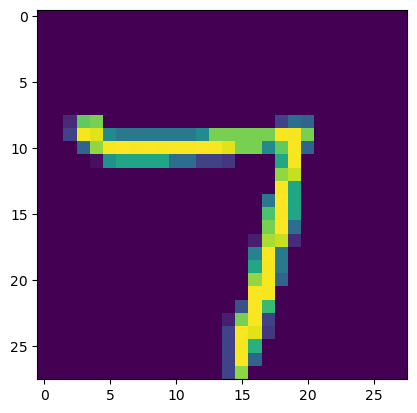

3


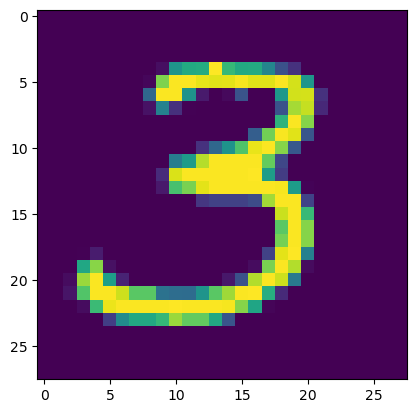

3


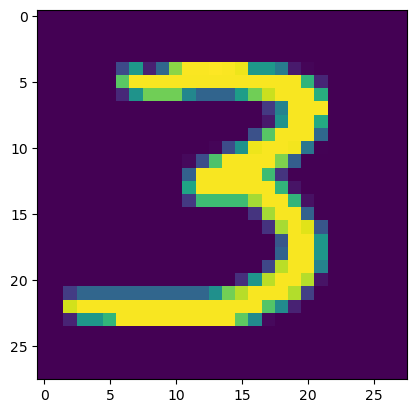

1


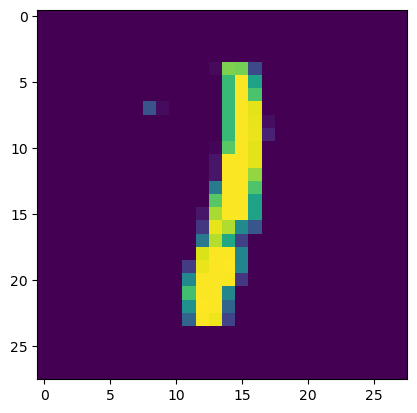

8


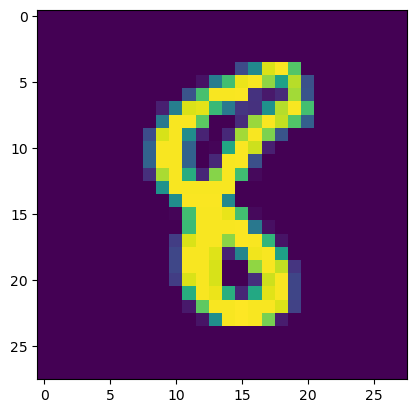

In [5]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [6]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        
        # Flatten layer to convert 28x28 images to 784-dimensional vectors
        self.flatten = nn.Flatten()
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(28 * 28, 128)  # Input: 784, Output: 128
        self.fc2 = nn.Linear(128, 64)       # Input: 128, Output: 64  
        self.fc3 = nn.Linear(64, 10)        # Input: 64, Output: 10 (classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Flatten the input tensor
        x = self.flatten(x)
        
        # First layer with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        # Second layer with ReLU activation
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Output layer (no activation - will use CrossEntropyLoss)
        x = self.fc3(x)
        
        return x

# Create an instance of the network
model = MNISTNet()

# Print model architecture
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test with my train_loader
dataiter = iter(train_loader)
batch = next(dataiter)
images, labels = batch
output = model(images)
print(f"\nBatch input shape: {images.shape}")
print(f"Batch output shape: {output.shape}")
print(f"Batch output values (first sample): {output[0].detach()}")


MNISTNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 109,386

Batch input shape: torch.Size([64, 1, 28, 28])
Batch output shape: torch.Size([64, 10])
Batch output values (first sample): tensor([ 0.1229, -0.2269,  0.0334, -0.0796,  0.1409,  0.0029,  0.1479, -0.1462,
        -0.4170,  0.0259])


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# Instantiate the model
model = MNISTNet()

# Define loss function
# CrossEntropyLoss is perfect for multi-class classification like MNIST
# It combines LogSoftmax + NLLLoss, handles class probabilities automatically
criterion = nn.CrossEntropyLoss()

# Define optimizer
# Adam is a great default choice: adaptive learning rates + momentum
# lr=0.001 is a good starting learning rate for most problems
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print setup info
print("Model instantiated successfully!")
print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

Model instantiated successfully!
Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Learning rate: 0.001


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
# Set device (CPU since I'm not using GPU)
device = torch.device('cpu')
model = model.to(device)

def train(num_epochs = 10, print_every = 250, optimizer=optimizer):
    """Train the model and print every `print_every` batches."""

    # Lists to store training history
    epoch_losses = []
    batch_losses = []

    print("Starting training...")
    print("=" * 60)

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        epoch_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            # Move data to device (CPU in my case)
            data, target = data.to(device), target.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(data)
            
            # Calculate loss
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            # Update running loss
            running_loss += loss.item()
            epoch_loss += loss.item()
            
            # Print progress during epoch
            if (batch_idx + 1) % print_every == 0:
                avg_loss = running_loss / print_every
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                    f'Batch [{batch_idx+1}/{len(train_loader)}], '
                    f'Average Loss: {avg_loss:.4f}')
                batch_losses.append(avg_loss)
                running_loss = 0.0
        
        # Calculate average loss for the epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] completed - Average Loss: {avg_epoch_loss:.4f}')
        print("-" * 60)
        
    return epoch_losses, batch_losses

epoch_losses, batch_losses = train()
print("Training completed!")
print(f"Final training loss: {epoch_losses[-1]:.4f}")

Starting training...
Epoch [1/10], Batch [250/938], Average Loss: 0.8508
Epoch [1/10], Batch [500/938], Average Loss: 0.4066
Epoch [1/10], Batch [750/938], Average Loss: 0.3527
Epoch [1/10] completed - Average Loss: 0.4915
------------------------------------------------------------
Epoch [2/10], Batch [250/938], Average Loss: 0.2804
Epoch [2/10], Batch [500/938], Average Loss: 0.2510
Epoch [2/10], Batch [750/938], Average Loss: 0.2483
Epoch [2/10] completed - Average Loss: 0.2554
------------------------------------------------------------
Epoch [3/10], Batch [250/938], Average Loss: 0.2193
Epoch [3/10], Batch [500/938], Average Loss: 0.2076
Epoch [3/10], Batch [750/938], Average Loss: 0.2103
Epoch [3/10] completed - Average Loss: 0.2096
------------------------------------------------------------
Epoch [4/10], Batch [250/938], Average Loss: 0.1957
Epoch [4/10], Batch [500/938], Average Loss: 0.1888
Epoch [4/10], Batch [750/938], Average Loss: 0.1791
Epoch [4/10] completed - Average L

Plot the training loss (and validation loss/accuracy, if recorded).

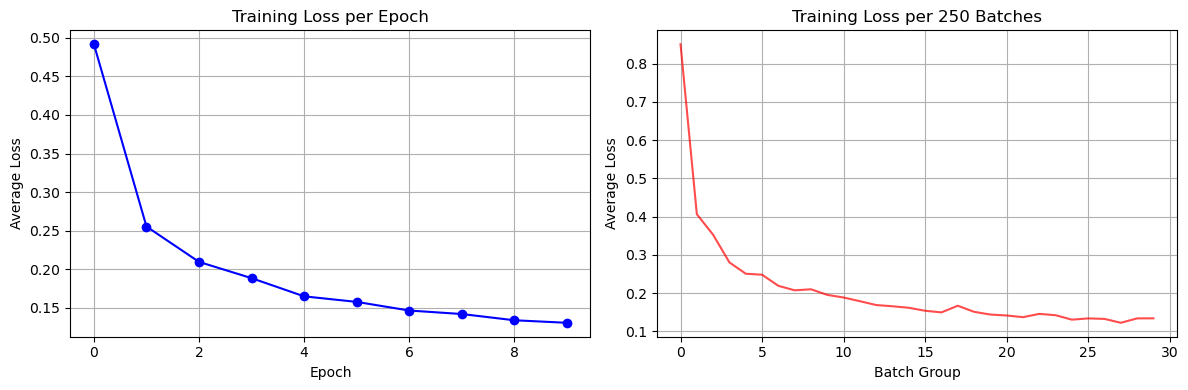

In [9]:
# Plot training loss
plt.figure(figsize=(12, 4))

# Plot epoch losses
plt.subplot(1, 2, 1)
plt.plot(epoch_losses, 'b-', marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)

# Plot batch losses
if batch_losses:
    plt.subplot(1, 2, 2)
    plt.plot(batch_losses, 'r-', alpha=0.7)
    plt.title('Training Loss per 250 Batches')
    plt.xlabel('Batch Group')
    plt.ylabel('Average Loss')
    plt.grid(True)

plt.tight_layout()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
def test():
    # Set model to evaluation mode
    model.eval()

    # Initialize variables for testing
    correct = 0
    total = 0
    class_correct = [0] * 10  # For per-class accuracy
    class_total = [0] * 10
    all_predictions = []
    all_targets = []

    print("Testing the model...")
    print("=" * 50)

    # Disable gradient computation for testing (saves memory and speeds up)
    with torch.no_grad():
        for data, target in test_loader:
            # Move data to device
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            outputs = model(data)
            
            # Get predictions (highest probability class)
            _, predicted = torch.max(outputs, 1)
            
            # Update total count
            total += target.size(0)
            
            # Update correct predictions
            correct += (predicted == target).sum().item()
            
            # Store predictions and targets for detailed analysis
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            
            # Per-class accuracy calculation
            for i in range(target.size(0)):
                label = target[i].item()
                class_total[label] += 1
                if predicted[i] == target[i]:
                    class_correct[label] += 1

    # Calculate overall accuracy
    accuracy = 100 * correct / total
    
    print(f"Test Results:")
    print(f"Total test samples: {total}")
    print(f"Correct predictions: {correct}")
    print(f"Overall Accuracy: {accuracy:.2f}%")

test()

Testing the model...
Test Results:
Total test samples: 10000
Correct predictions: 9726
Overall Accuracy: 97.26%


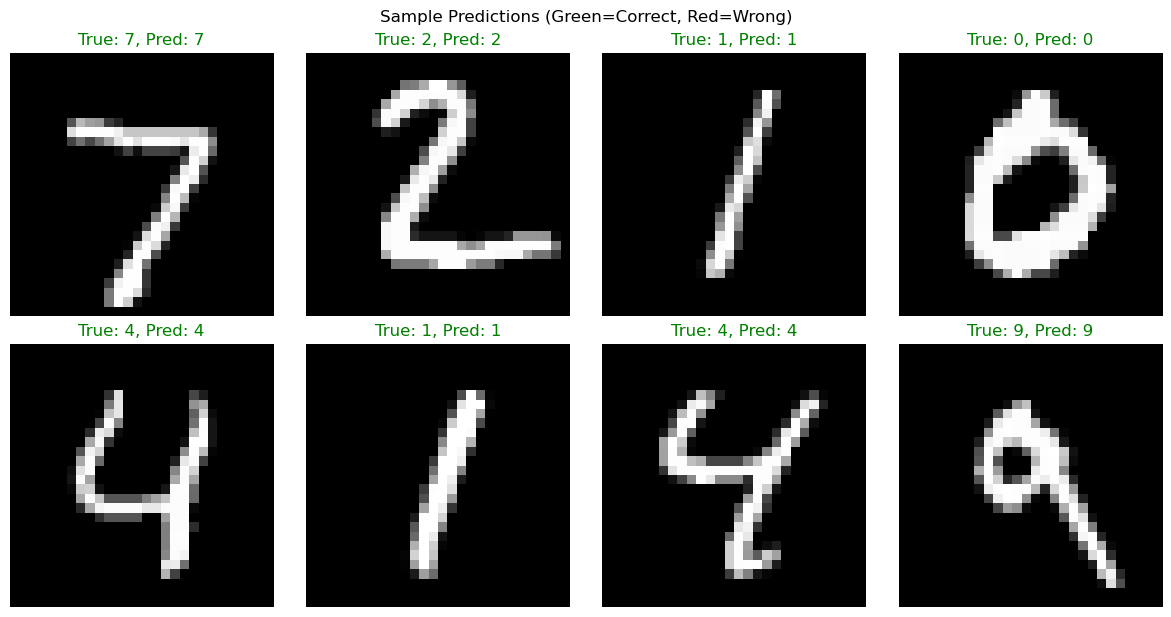

In [11]:
# Visualize some predictions
def visualize_predictions(num_samples=8):
    """Visualize some test predictions"""
    # Get one batch of test data
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    # Get predictions
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    # Plot results
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        # Convert to numpy and remove channel dimension
        img = images[i].cpu().squeeze().numpy()
        
        # Denormalize image (reverse the normalization we applied)
        img = img * 0.5 + 0.5  # From [-1,1] back to [0,1]
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
        axes[i].axis('off')
        
        # Color the title based on correctness
        if labels[i].item() == predicted[i].item():
            axes[i].title.set_color('green')
        else:
            axes[i].title.set_color('red')
    
    plt.tight_layout()
    plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', y=1.02)
    plt.show()

# Show sample predictions
visualize_predictions()

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [12]:
improved_optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
train(num_epochs = 25, print_every = 938, optimizer=improved_optimizer)


Starting training...
Epoch [1/25], Batch [938/938], Average Loss: 0.1077
Epoch [1/25] completed - Average Loss: 0.1077
------------------------------------------------------------
Epoch [2/25], Batch [938/938], Average Loss: 0.1021
Epoch [2/25] completed - Average Loss: 0.1021
------------------------------------------------------------
Epoch [3/25], Batch [938/938], Average Loss: 0.0980
Epoch [3/25] completed - Average Loss: 0.0980
------------------------------------------------------------
Epoch [4/25], Batch [938/938], Average Loss: 0.0971
Epoch [4/25] completed - Average Loss: 0.0971
------------------------------------------------------------
Epoch [5/25], Batch [938/938], Average Loss: 0.0971
Epoch [5/25] completed - Average Loss: 0.0971
------------------------------------------------------------
Epoch [6/25], Batch [938/938], Average Loss: 0.0937
Epoch [6/25] completed - Average Loss: 0.0937
------------------------------------------------------------
Epoch [7/25], Batch [938/

([0.10774545078185686,
  0.1020531419174138,
  0.09799999112575086,
  0.09714201441122049,
  0.0971301094055978,
  0.09365692816581378,
  0.09379280374836185,
  0.09024208913773679,
  0.09029636096243046,
  0.08893367499540022,
  0.08980718872863362,
  0.08795514676882736,
  0.08885182609269296,
  0.08410231725236814,
  0.08211899085118295,
  0.08312582796531866,
  0.08130503440651098,
  0.08185026696302307,
  0.08008249725814837,
  0.0793824629922177,
  0.07866356615423918,
  0.0774551414465631,
  0.07985099863463532,
  0.07816950437019089,
  0.07749282028689893],
 [0.10774545078185686,
  0.1020531419174138,
  0.09799999112575086,
  0.09714201441122049,
  0.0971301094055978,
  0.09365692816581378,
  0.09379280374836185,
  0.09024208913773679,
  0.09029636096243046,
  0.08893367499540022,
  0.08980718872863362,
  0.08795514676882736,
  0.08885182609269296,
  0.08410231725236814,
  0.08211899085118295,
  0.08312582796531866,
  0.08130503440651098,
  0.08185026696302307,
  0.080082497258

In [13]:
test()

Testing the model...
Test Results:
Total test samples: 10000
Correct predictions: 9745
Overall Accuracy: 97.45%


Even changing the optimizer and raising the number of epochs, the improvement was not significant. The accuracy increased from 97.26% to around 97.45%.

## Saving your model
Using `torch.save`, save your model for future loading.

In [15]:
torch.save(model.state_dict(), 'mnist_model.pth')